In [2]:
import tensorflow as tf 
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [15]:
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNEL = 3

In [7]:
# read images in batches through tf_datasets
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",shuffle =True,image_size = (IMAGE_SIZE,IMAGE_SIZE),batch_size =BATCH_SIZE )

Found 2152 files belonging to 3 classes.


In [11]:
class_names=dataset.class_names
class_names    

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)#68 because batch of 32

68

In [17]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())#0,1,2 are classes

(32, 256, 256, 3)
[1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 2 1 1 0 1 1 0 1 1 1 0 1 1]


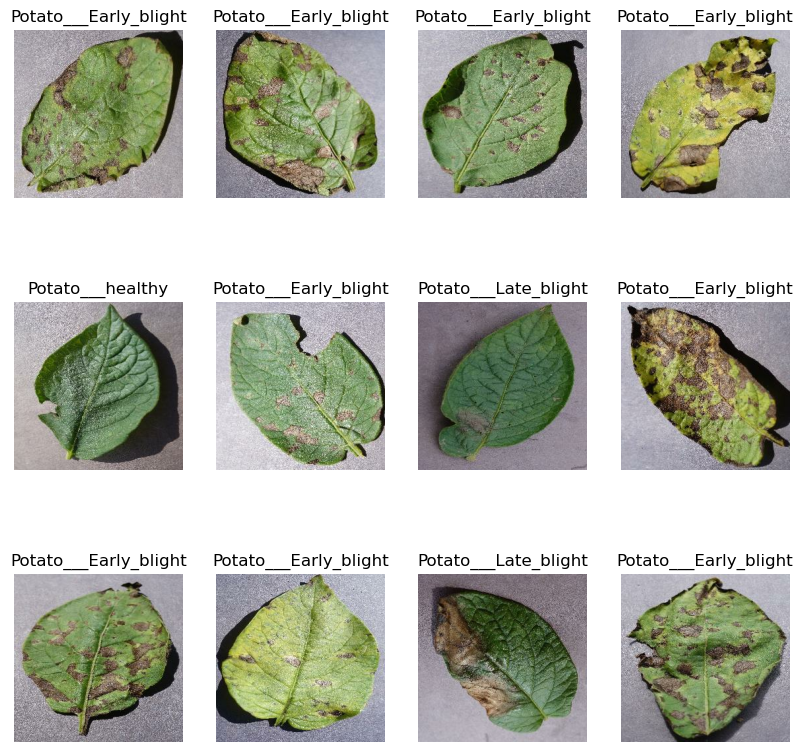

In [43]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
82%==traning
20% == 10%validation 10% test # we use validation data after each epochs

In [44]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [45]:
train_ds = dataset.take(54)#54 batches

In [46]:
len(train_ds)

54

In [47]:
test_ds = dataset.skip(54)
# from this need to take validation

In [49]:
len(dataset)*0.1

6.800000000000001

In [51]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [53]:
test_ds = test_ds.skip(6)

In [60]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split=0.1,shuffle =True,shuffle_size= 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    val_ds = ds.skip(train_size).skip(val_size)
   
    
    return train_ds,val_ds,test_ds

In [62]:
train_ds ,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [63]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
8
8


In [66]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)#chahe is to keep in memory, prefech when gpu is bussy it will shift to task cpu
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [69]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [71]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [77]:
input_shape = (BATCH_SIZE , IMAGE_SIZE,IMAGE_SIZE,CHANNEL
              )
n_classes= 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu",input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation ="softmax")
    
])

model.build(input_shape =input_shape)

In [79]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [80]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
    
)

In [81]:
history= model.fit(train_ds,
         epochs = 50,
         batch_size = BATCH_SIZE,
         verbose =1,
         validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 38s 238ms/step - loss: 0.8594 - accuracy: 0.5353 - val_loss: 0.5893 - val_accuracy: 0.7227
Epoch 2/50
54/54 [==============================] - 11s 211ms/step - loss: 0.5311 - accuracy: 0.7523 - val_loss: 0.7961 - val_accuracy: 0.6719
Epoch 3/50
54/54 [==============================] - 12s 215ms/step - loss: 0.3806 - accuracy: 0.8409 - val_loss: 0.5967 - val_accuracy: 0.6875
Epoch 4/50
54/54 [==============================] - 11s 211ms/step - loss: 0.2569 - accuracy: 0.8906 - val_loss: 0.1518 - val_accuracy: 0.9414
Epoch 5/50
54/54 [==============================] - 11s 210ms/step - loss: 0.1524 - accuracy: 0.9404 - val_loss: 0.2283 - val_accuracy: 0.8984
Epoch 6/50
54/54 [==============================] - 12s 216ms/step - loss: 0.1420 - accuracy: 0.9444 - val_loss: 0.0835 - val_accuracy: 0.9648
Epoch 7/50
54/54 [==============================] - 12s 222ms/step - loss: 0.0676 - accuracy: 0.9757 - val_loss: 0.1105 - val_accuracy: 0.9453

54/54 [==============================] - 11s 208ms/step - loss: 0.0727 - accuracy: 0.9763 - val_loss: 0.0333 - val_accuracy: 0.9844
Epoch 42/50
54/54 [==============================] - 11s 209ms/step - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0288 - val_accuracy: 0.9883
Epoch 43/50
54/54 [==============================] - 11s 208ms/step - loss: 0.0373 - accuracy: 0.9850 - val_loss: 0.0569 - val_accuracy: 0.9844
Epoch 44/50
54/54 [==============================] - 11s 208ms/step - loss: 0.0320 - accuracy: 0.9890 - val_loss: 0.0182 - val_accuracy: 0.9922
Epoch 45/50
54/54 [==============================] - 11s 211ms/step - loss: 0.0144 - accuracy: 0.9948 - val_loss: 0.0124 - val_accuracy: 0.9922
Epoch 46/50
54/54 [==============================] - 11s 208ms/step - loss: 0.0062 - accuracy: 0.9977 - val_loss: 0.0487 - val_accuracy: 0.9883
Epoch 47/50
54/54 [==============================] - 11s 209ms/step - loss: 0.0105 - accuracy: 0.9965 - val_loss: 0.0417 - val_accuracy: 0.9883
Epoc

In [82]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 80ms/step - loss: 0.0200 - accuracy: 0.9914


In [83]:
scores 

[0.019982464611530304, 0.9913793206214905]

In [84]:
history

In [86]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 54}

In [87]:
history.history["accuracy"]

[0.5353009104728699,
 0.7523148059844971,
 0.8408564925193787,
 0.890625,
 0.9403935074806213,
 0.9444444179534912,
 0.9756944179534912,
 0.9623842835426331,
 0.9762731194496155,
 0.9496527910232544,
 0.9820601940155029,
 0.96875,
 0.9646990895271301,
 0.9803240895271301,
 0.9872685074806213,
 0.9635416865348816,
 0.9704861044883728,
 0.9849537014961243,
 0.9872685074806213,
 0.9762731194496155,
 0.9866898059844971,
 0.9947916865348816,
 0.9936342835426331,
 0.9832175970077515,
 0.9872685074806213,
 0.9728009104728699,
 0.9872685074806213,
 0.9971064925193787,
 0.9976851940155029,
 0.9930555820465088,
 0.9814814925193787,
 0.9901620149612427,
 0.9716435074806213,
 0.9797453880310059,
 0.9930555820465088,
 0.9791666865348816,
 0.9814814925193787,
 0.9924768805503845,
 0.9942129850387573,
 0.9936342835426331,
 0.9762731194496155,
 0.9965277910232544,
 0.9849537014961243,
 0.9890046119689941,
 0.9947916865348816,
 0.9976851940155029,
 0.9965277910232544,
 0.9872685074806213,
 0.9942129850

In [88]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [89]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Traning loss vs valadation loss')

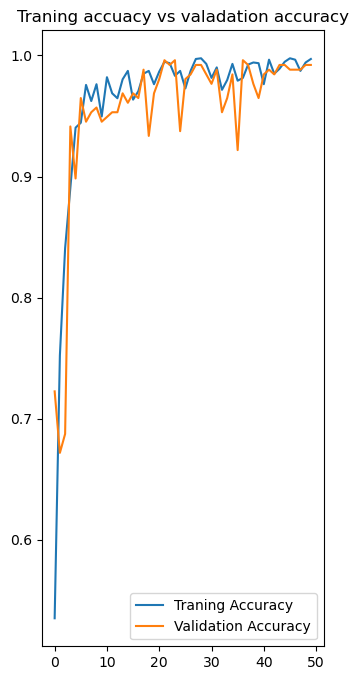

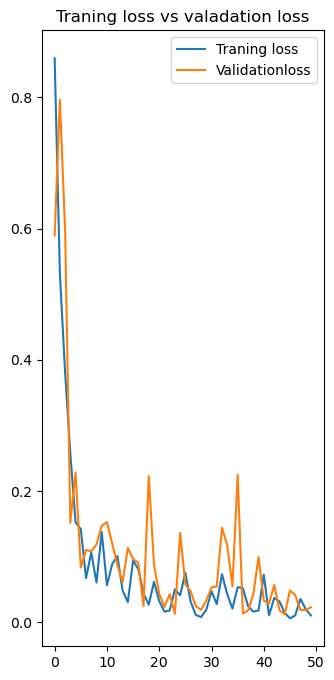

In [96]:
plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.plot(range(50),acc,label="Traning Accuracy")
plt.plot(range(50),val_acc,label="Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Traning accuacy vs valadation accuracy")


plt.figure(figsize =(8,8))
plt.subplot(1,2,2)
plt.plot(range(50),loss,label="Traning loss")
plt.plot(range(50),val_loss,label="Validationloss")
plt.legend(loc = "upper right")
plt.title("Traning loss vs valadation loss")

In [109]:
import numpy as np

frist image to predict
first image's actual label: Potato___Late_blight
1/1 [==============================] - 0s 49ms/step
predicted label Potato___Late_blight


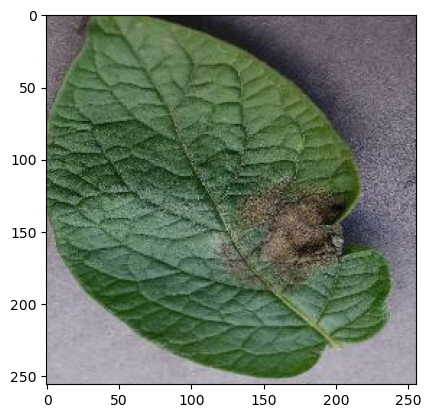

In [115]:
for image_batch , label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
#     print(image_batch[0].numpy().astype("uint8"))
    first_label = label_batch[0].numpy()
    print("frist image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction  =model.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])
    
    
    

In [127]:
def predict(model,img):
    img_array =tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)# creat batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence =round(100*(np.max(predictions[0])),2)
    
    return predicted_class,confidence
    

1/1 [==============================] - 0s 16ms/step


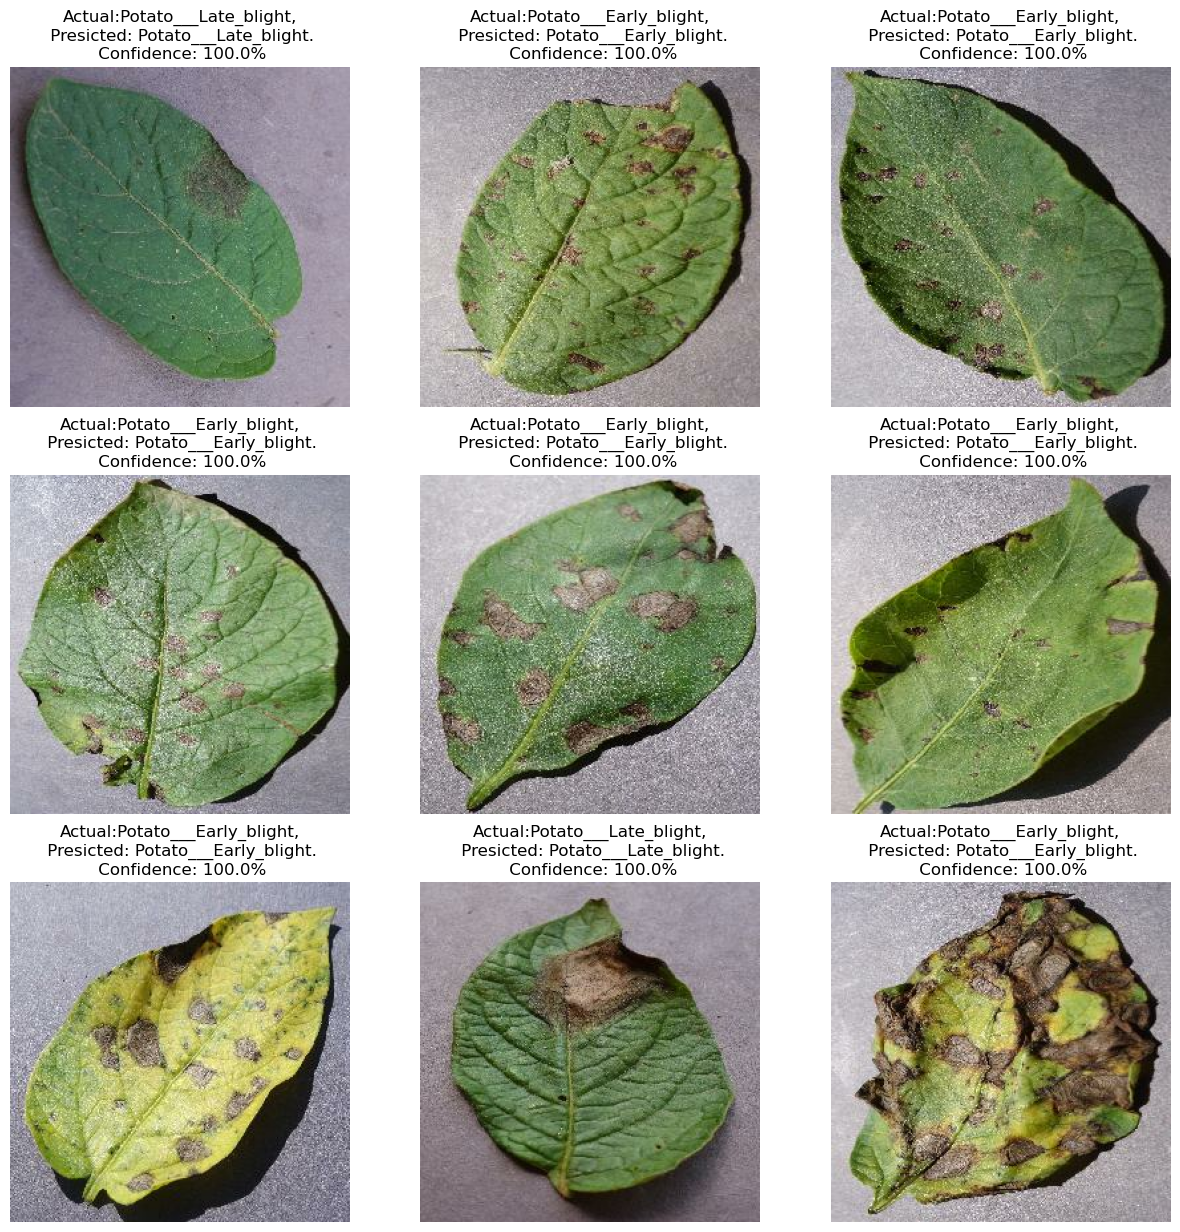

In [134]:
plt.figure(figsize=(15,15))
for image,labels in test_ds.take(1):
    for i in range(9):
        
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        
        predicted_class,confidence = predict(model, image[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Presicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [143]:
# model_version = 2
# model.save(f"..\model\ {model_version}")

In [142]:
# import os
# model_version = max([int(i) for i in os.listdir("../model")+[0]])+1
# model.save(f"../model/ {model_version}")